In [47]:
import pandas as pd
import numpy as np
np.random.seed(27042018)

import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import seaborn as sns

from collections import defaultdict

%matplotlib inline

In [2]:
#Let's load it
workbook=pd.ExcelFile('../input/house.csv.xlsx')
d={} # start with an empty dictionary
for sheet_name in workbook.sheet_names:
    df=workbook.parse(sheet_name)
    d[sheet_name]=df

In [9]:
#what we have here...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null object
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null object
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(15), object(3)
memory usage: 3.5+ MB



## Checking Data

For a starter I wanna know few simple things:
1. Number of rows? (all objects)
2. Number of columns? (features of objects)
3. Which one is target variable?
4. What is the problem to solve? (regression?)
5. Are there missing data?
6. How much memory we are using? #Should I do something with that?

- There are 21613 rows (objects)
- Third line says 'total 21 columns'
- 'price' is target variable
- Regression
- No
- 3.5 mb 

In [32]:
#more precisely about missing data
df.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
price_pred       False
dtype: bool

In [10]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2017-02-25 00:00:00,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [33]:
df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_pred
21608,263000018,20140521T000000,360000.0,3,2017-02-05 00:00:00,1530,1131,3,0,0,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,715000.0
21609,6600060120,20150223T000000,400000.0,4,2017-02-05 00:00:00,2310,5813,2,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,378000.0
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2,0,0,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,190000.0
21611,291310100,20150116T000000,400000.0,3,2017-02-05 00:00:00,1600,2388,2,0,0,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,299950.0
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2,0,0,...,1020,0,2008,0,98144,47.5941,-122.299,1020,1357,515000.0


In [80]:
df.sample(15)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_cat
7703,9294300515,20141024T000000,775000.0,3,2,2010,7017,2,0,3,...,2010,0,1951,1988,98115,47.6828,-122.267,2450,6045,-1
2207,1545802830,20150309T000000,258500.0,3,2,1460,7930,1,0,0,...,1460,0,1989,0,98038,47.3590,-122.049,1630,7930,-1
1111,7683800200,20150402T000000,275000.0,2,2017-01-05 00:00:00,1270,32175,1,0,0,...,1270,0,1947,0,98003,47.3347,-122.304,1270,10200,-1
21003,2767704251,20150416T000000,514700.0,3,2017-03-25 00:00:00,1310,1072,2,0,0,...,1060,250,2008,0,98107,47.6744,-122.374,1160,1266,-1
1249,472000055,20140514T000000,546000.0,3,1.75,2000,5000,1,0,0,...,1110,890,1921,0,98117,47.6859,-122.399,1750,5000,-1
14079,5702380770,20150428T000000,280000.0,4,2017-02-25 00:00:00,1600,7916,2,0,0,...,1600,0,1991,0,98022,47.1940,-121.981,1540,7242,-1
5590,5739600427,20150311T000000,725000.0,3,1.75,1630,9000,1,0,0,...,960,670,1955,0,98004,47.6023,-122.205,1880,9000,-1
2151,2124069078,20141211T000000,525000.0,2,2017-01-05 00:00:00,1480,43645,1,0,0,...,1480,0,1974,2006,98027,47.5484,-122.045,1600,34326,-1
7236,1245002391,20141022T000000,1400000.0,5,2017-04-25 00:00:00,4230,6907,2,0,0,...,3450,780,2008,0,98033,47.6866,-122.205,2650,8076,-1
9701,2946003415,20140516T000000,174500.0,2,1,1010,5200,1,0,0,...,1010,0,1955,0,98198,47.4166,-122.323,1580,7500,-1


In [68]:
#some descripitve stats - helpful for numeric data
df.describe()

,id,price,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_cat
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.0
mean,4.580302e+09,5.400881e+05,3.370842,2079.899736,1.510697e+04,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,-1.0
std,2.876566e+09,3.671272e+05,0.930062,918.440897,4.142051e+04,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.0
min,1.000102e+06,7.500000e+04,0.000000,290.000000,5.200000e+02,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,-1.0
25%,2.123049e+09,3.219500e+05,3.000000,1427.000000,5.040000e+03,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,-1.0
50%,3.904930e+09,4.500000e+05,3.000000,1910.000000,7.618000e+03,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,-1.0
75%,7.308900e+09,6.450000e+05,4.000000,2550.000000,1.068800e+04,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,-1.0
max,9.900000e+09,7.700000e+06,33.000000,13540.000000,1.651359e+06,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,-1.0


In [71]:
#how many values
df.apply(lambda x: x.nunique())

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
bedrooms_cat         1
dtype: int64

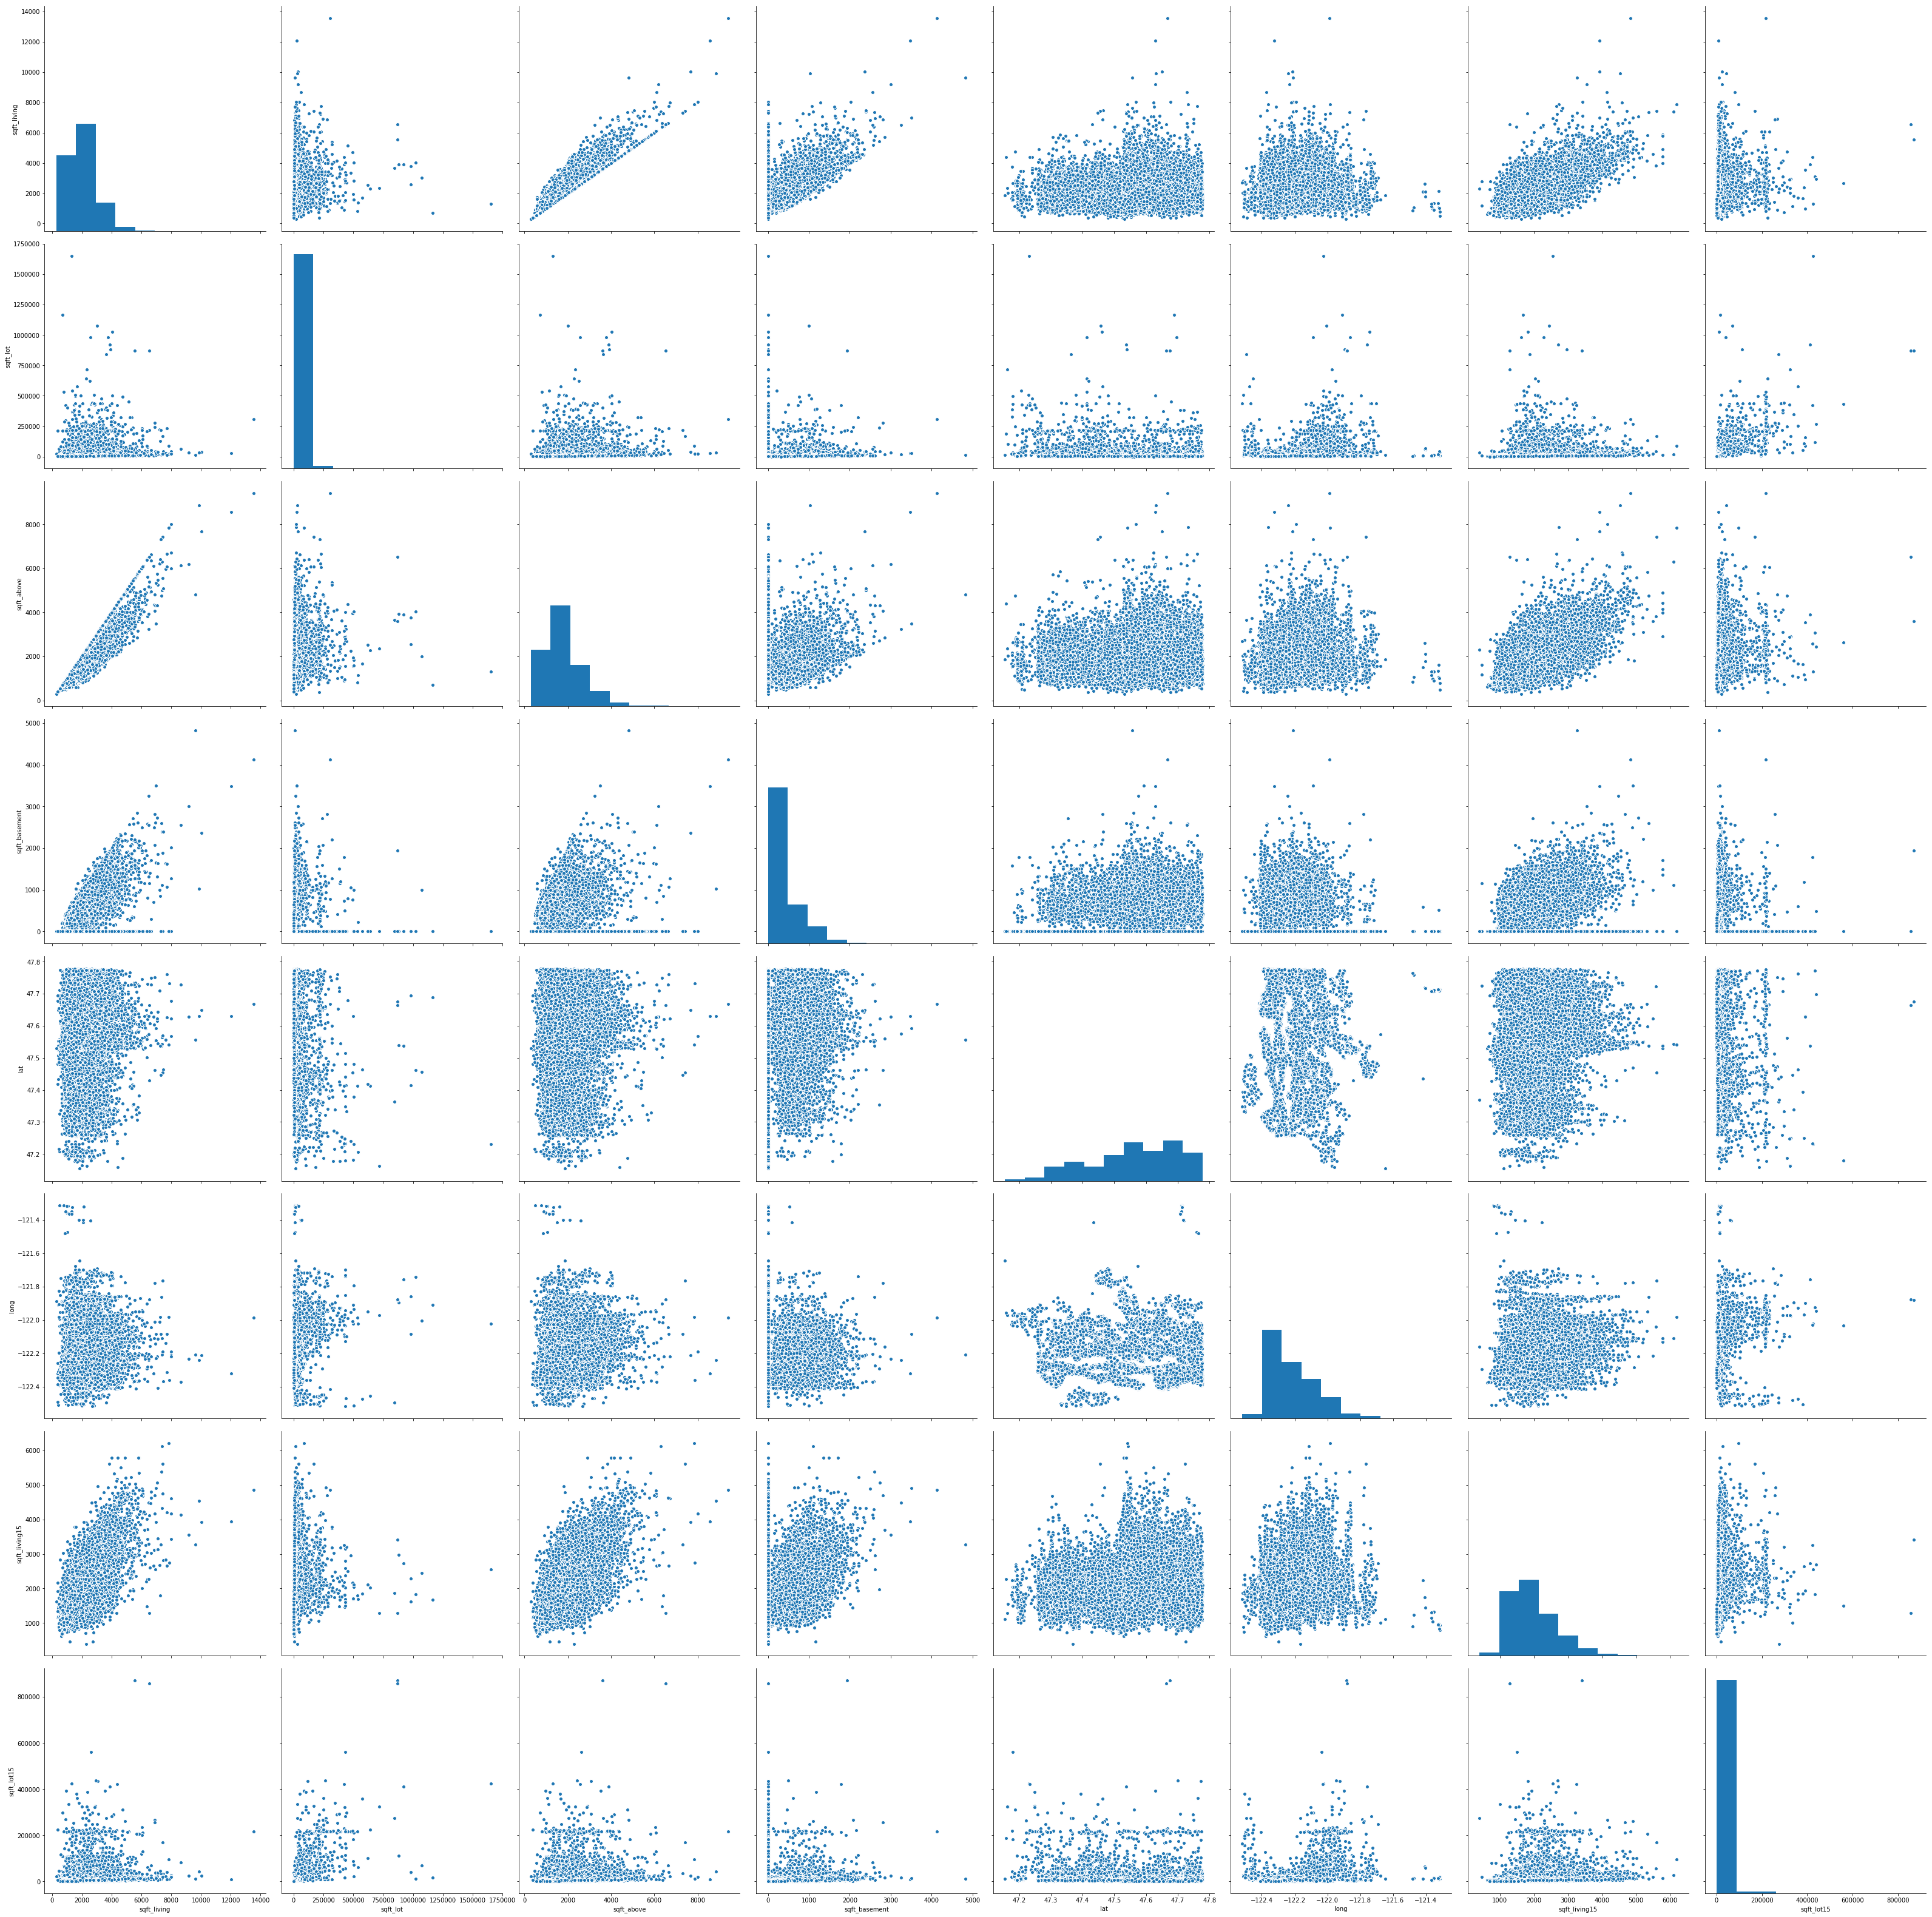

In [24]:
numerous_feats = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
sns.pairplot(df[numerous_feats], size=5.5 );

- I can see some outlier values


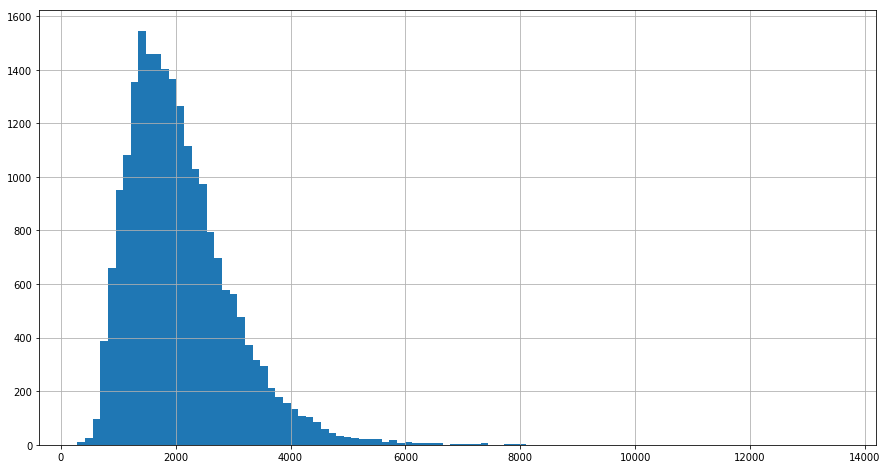

In [6]:
df.sqft_living.hist(bins=100, figsize=(15, 8));

## Sqft_living

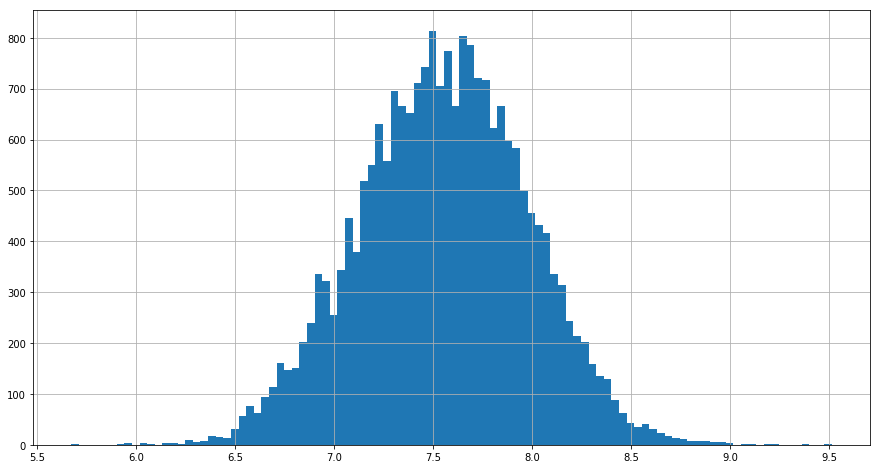

In [7]:
np.log( df.sqft_living ).hist(bins=100, figsize=(15, 8));

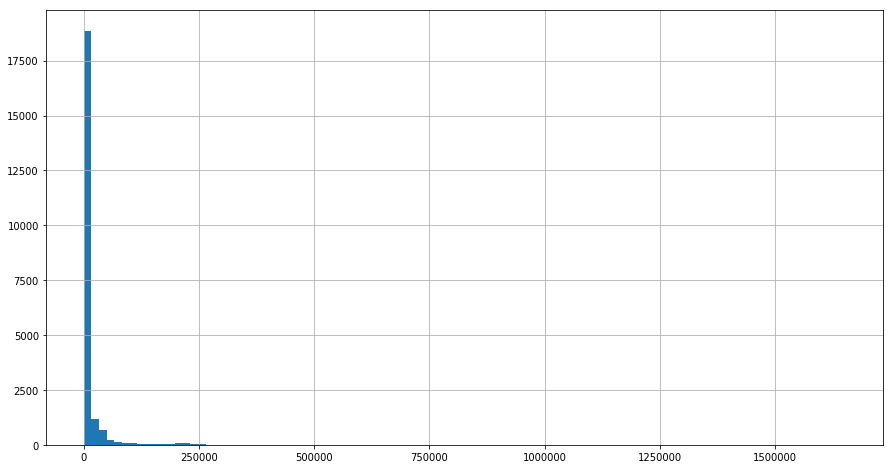

In [8]:
df.sqft_lot.hist(bins=100, figsize=(15, 8));

## Sqft_lot

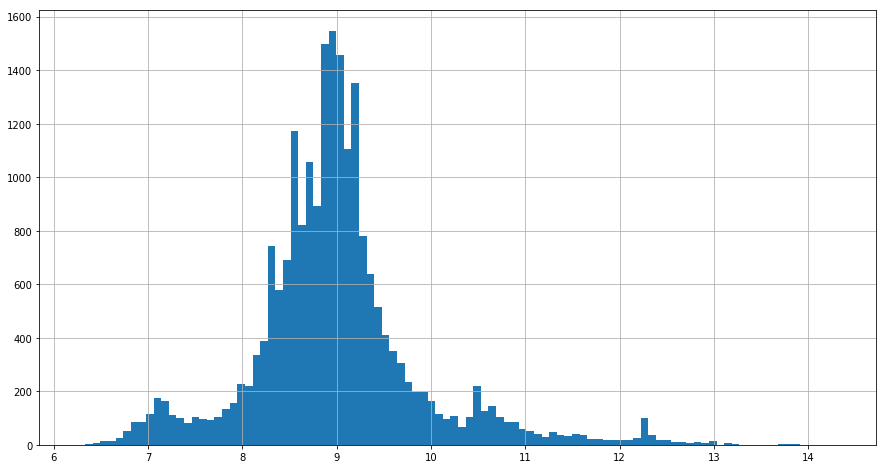

In [9]:
np.log( df.sqft_lot ).hist(bins=100, figsize=(15, 8));

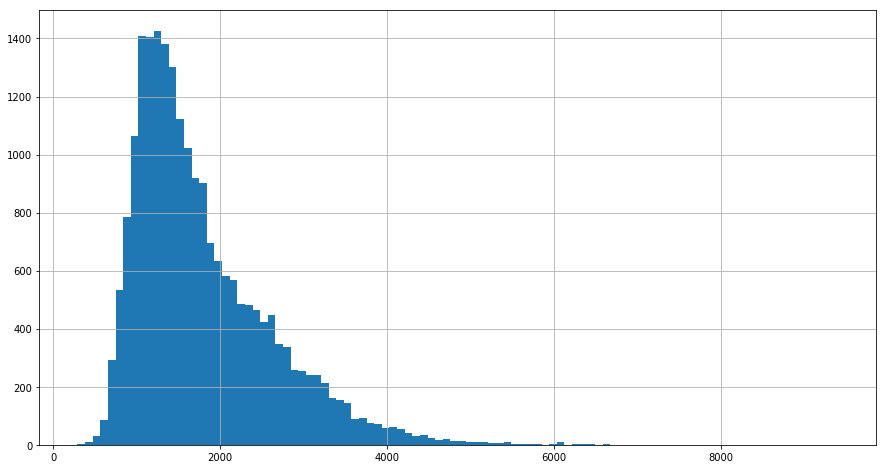

In [10]:
df.sqft_above.hist(bins=100, figsize=(15, 8));

## Sqft_above

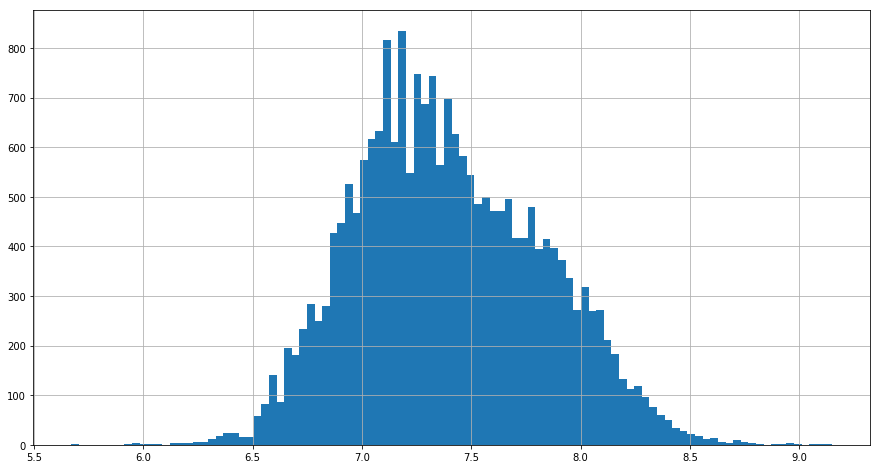

In [11]:
np.log( df.sqft_above ).hist(bins=100, figsize=(15, 8));

## Sqft_basement

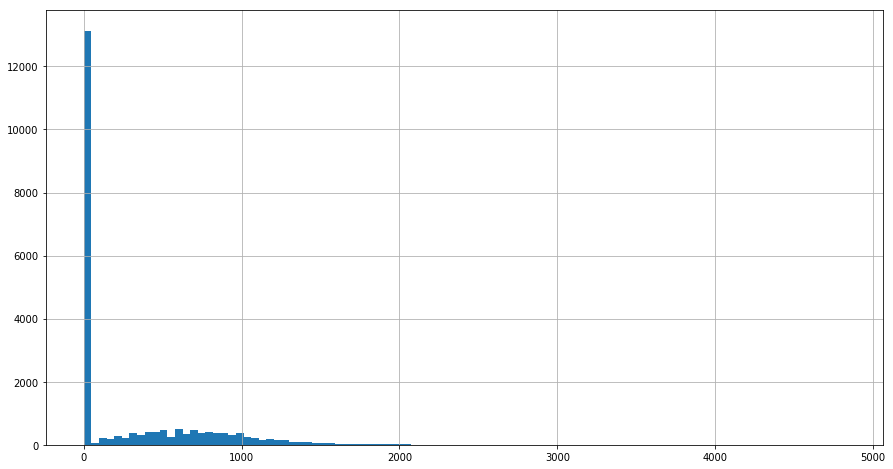

In [12]:
df.sqft_basement.hist(bins=100, figsize=(15, 8));

## Latitiude

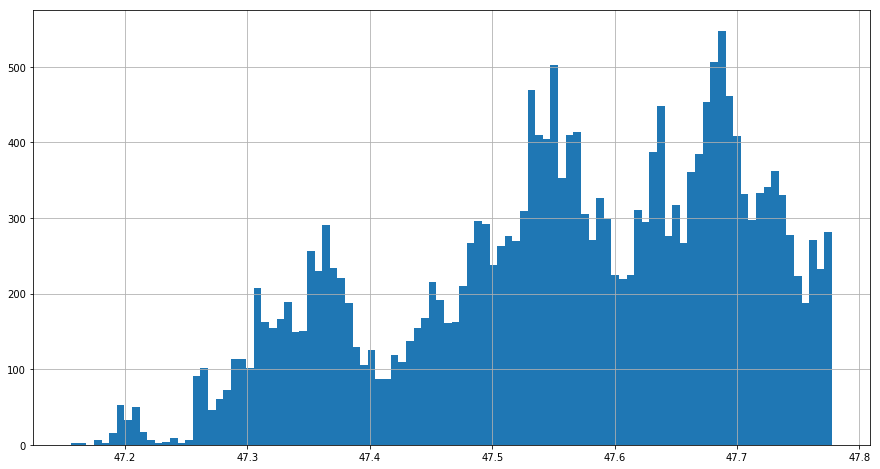

In [15]:
df.lat.hist(bins=100, figsize=(15, 8));

## Longtitiude

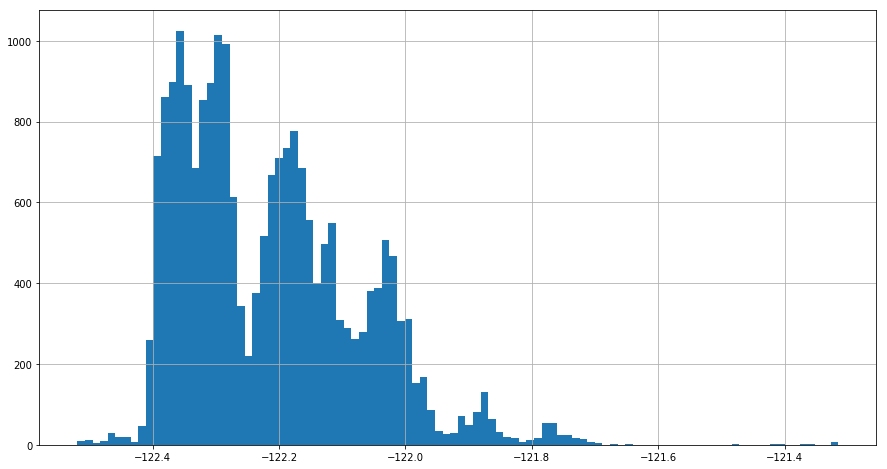

In [16]:
df.long.hist(bins=100, figsize=(15, 8));

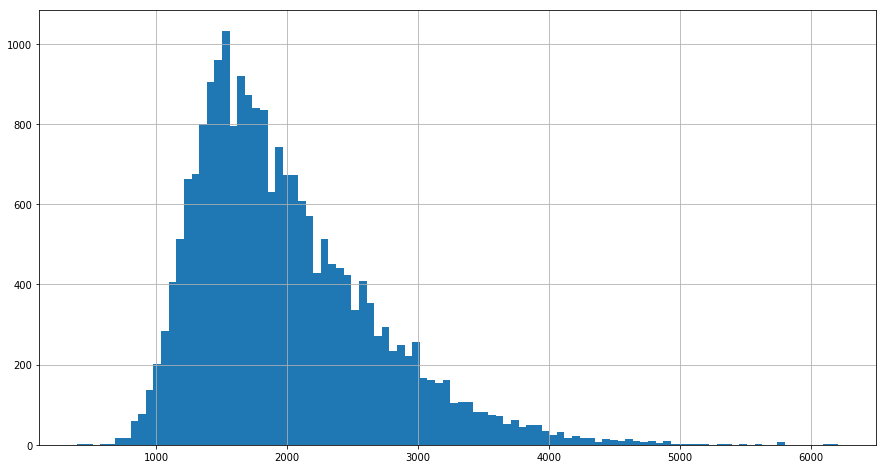

In [18]:
df.sqft_living15.hist(bins=100, figsize=(15, 8));

## sqft_living15

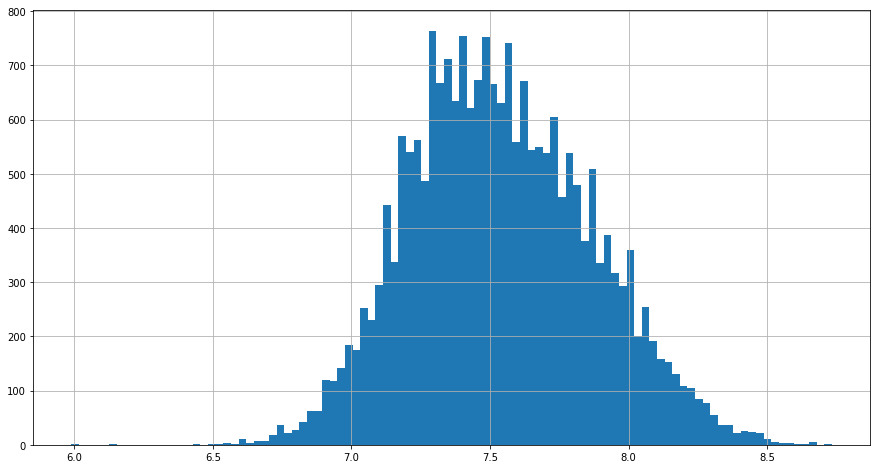

In [19]:
np.log( df.sqft_living15 ).hist(bins=100, figsize=(15, 8));

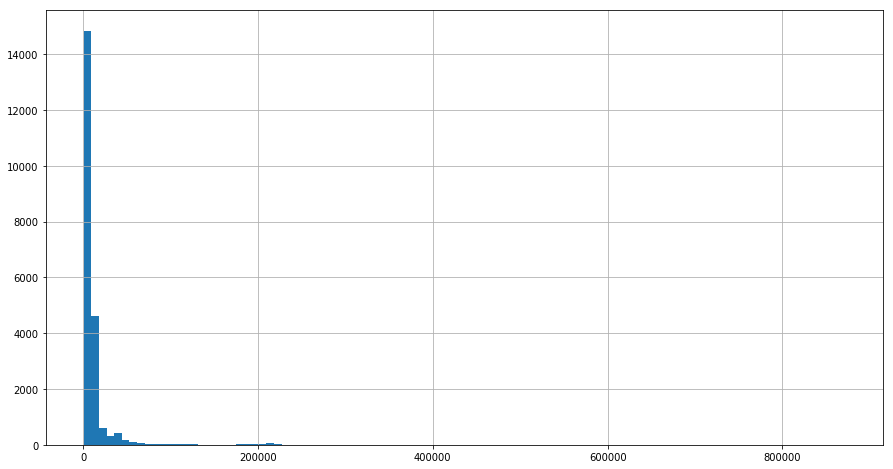

In [20]:
df.sqft_lot15.hist(bins=100, figsize=(15, 8));

## sqft_lot15

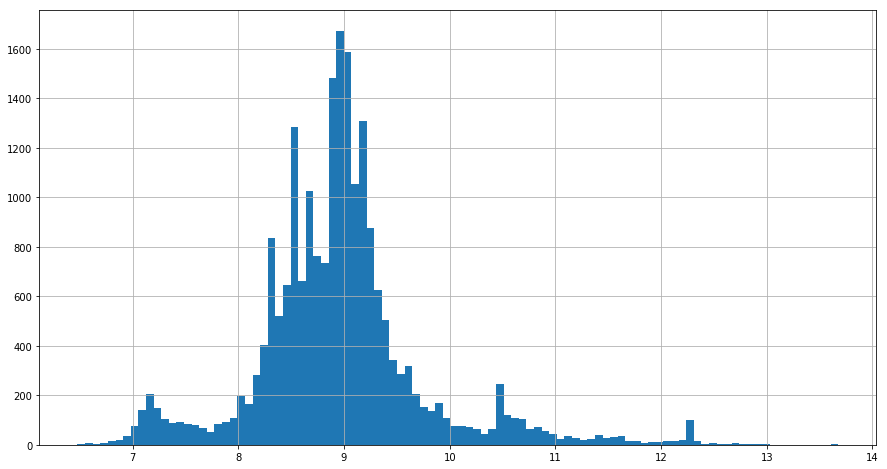

In [21]:
np.log( df.sqft_lot15 ).hist(bins=100, figsize=(15, 8));

In [70]:
df['bedrooms'].value_counts(normalize=True)

3     0.454541
4     0.318419
2     0.127701
5     0.074076
6     0.012585
1     0.009207
7     0.001758
8     0.000601
0     0.000601
9     0.000278
10    0.000139
11    0.000046
33    0.000046
Name: bedrooms, dtype: float64

First five cover 92%, so I'm going to throw the rest into 'other' category.

In [42]:
#map_bedrooms = defaultdict(lambda: -1, 
                            {'3': 1,
                             '4': 2,
                             '2': 3,
                             '5': 4,
                             '6': 5})

df['bedrooms_cat'] = df['bedrooms'].map(map_bedrooms) 

!!!

In [26]:
df['bathrooms'].value_counts(normalize=True)

2017-02-05 00:00:00    0.248924
1                      0.178226
1.75                   0.141026
2017-02-25 00:00:00    0.094712
2                      0.089298
2017-01-05 00:00:00    0.066904
2.75                   0.054828
3                      0.034840
2017-03-05 00:00:00    0.033822
2017-03-25 00:00:00    0.027252
3.75                   0.007172
4                      0.006293
2017-04-05 00:00:00    0.004627
2017-04-25 00:00:00    0.003655
0.75                   0.003331
4.75                   0.001064
5                      0.000972
2017-05-25 00:00:00    0.000601
0                      0.000463
2017-05-05 00:00:00    0.000463
2017-01-25 00:00:00    0.000416
6                      0.000278
0.5                    0.000185
5.75                   0.000185
2017-06-25 00:00:00    0.000093
8                      0.000093
2017-06-05 00:00:00    0.000093
6.75                   0.000093
7.75                   0.000046
2017-07-05 00:00:00    0.000046
Name: bathrooms, dtype: float64

In [26]:
df.corr()

,id,price,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_pred
id,1.000000e+00,-1.676220e-02,1.286277e-03,-1.225777e-02,-1.321087e-01,-2.721094e-03,1.159237e-02,-2.378260e-02,8.130454e-03,-1.084213e-02,-5.151125e-03,2.138013e-02,-1.690696e-02,-8.224325e-03,-1.890932e-03,2.079859e-02,-2.901004e-03,-1.387979e-01,1.767686e-15
price,-1.676220e-02,1.000000e+00,3.083496e-01,7.020351e-01,8.966086e-02,2.663694e-01,3.972935e-01,3.636179e-02,6.674343e-01,6.055673e-01,3.238160e-01,5.401153e-02,1.264338e-01,-5.320285e-02,3.070035e-01,2.162624e-02,5.853789e-01,8.244715e-02,3.454533e-15
bedrooms,1.286277e-03,3.083496e-01,1.000000e+00,5.766707e-01,3.170324e-02,-6.582479e-03,7.953185e-02,2.847210e-02,3.569667e-01,4.776002e-01,3.030934e-01,1.541781e-01,1.884082e-02,-1.526685e-01,-8.931010e-03,1.294730e-01,3.916375e-01,2.924422e-02,2.429753e-15
sqft_living,-1.225777e-02,7.020351e-01,5.766707e-01,1.000000e+00,1.728257e-01,1.038178e-01,2.846112e-01,-5.875259e-02,7.627045e-01,8.765966e-01,4.350430e-01,3.180488e-01,5.536293e-02,-1.994300e-01,5.252946e-02,2.402233e-01,7.564203e-01,1.832856e-01,7.139358e-15
sqft_lot,-1.321087e-01,8.966086e-02,3.170324e-02,1.728257e-01,1.000000e+00,2.160368e-02,7.471011e-02,-8.958250e-03,1.136211e-01,1.835123e-01,1.528620e-02,5.308037e-02,7.643505e-03,-1.295745e-01,-8.568279e-02,2.295209e-01,1.446082e-01,7.185568e-01,3.942156e-16
waterfront,-2.721094e-03,2.663694e-01,-6.582479e-03,1.038178e-01,2.160368e-02,1.000000e+00,4.018574e-01,1.665316e-02,8.277491e-02,7.207459e-02,8.058794e-02,-2.616109e-02,9.288484e-02,3.028473e-02,-1.427378e-02,-4.191020e-02,8.646314e-02,3.070328e-02,2.109581e-15
view,1.159237e-02,3.972935e-01,7.953185e-02,2.846112e-01,7.471011e-02,4.018574e-01,1.000000e+00,4.598974e-02,2.513206e-01,1.676493e-01,2.769466e-01,-5.343985e-02,1.039173e-01,8.482692e-02,6.156732e-03,-7.839971e-02,2.804391e-01,7.257457e-02,3.588217e-15
condition,-2.378260e-02,3.636179e-02,2.847210e-02,-5.875259e-02,-8.958250e-03,1.665316e-02,4.598974e-02,1.000000e+00,-1.446737e-01,-1.582136e-01,1.741049e-01,-3.614166e-01,-6.061779e-02,3.025524e-03,-1.494101e-02,-1.065004e-01,-9.282427e-02,-3.405523e-03,1.847664e-14
grade,8.130454e-03,6.674343e-01,3.569667e-01,7.627045e-01,1.136211e-01,8.277491e-02,2.513206e-01,-1.446737e-01,1.000000e+00,7.559229e-01,1.683918e-01,4.469632e-01,1.441428e-02,-1.848621e-01,1.140841e-01,1.983722e-01,7.132021e-01,1.192479e-01,1.371446e-14
sqft_above,-1.084213e-02,6.055673e-01,4.776002e-01,8.765966e-01,1.835123e-01,7.207459e-02,1.676493e-01,-1.582136e-01,7.559229e-01,1.000000e+00,-5.194331e-02,4.238984e-01,2.328469e-02,-2.611900e-01,-8.164986e-04,3.438030e-01,7.318703e-01,1.940499e-01,-1.384326e-14


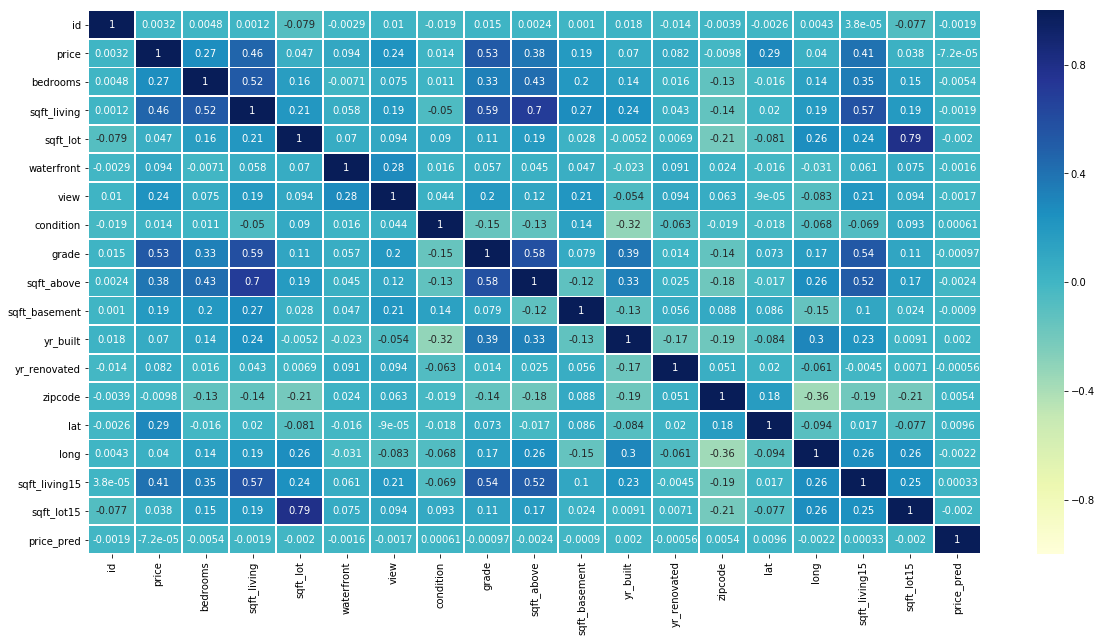

In [43]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(method='kendall'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

- 0.46 corr between price & sqft_living
- 0.59 corr between grade & sqft_living
- 0.27 corr between price & bedrooms - more bedrooms, price goes up
- 0.24 corr between price & view - goes up with a nice view
- 0.38 corr between price & sqft_above
- 0.29 corr between price & lat

In [ ]:
df['Big_flat'] = ((df.Relationship == 'Husband') & (data.Race == 'White'))

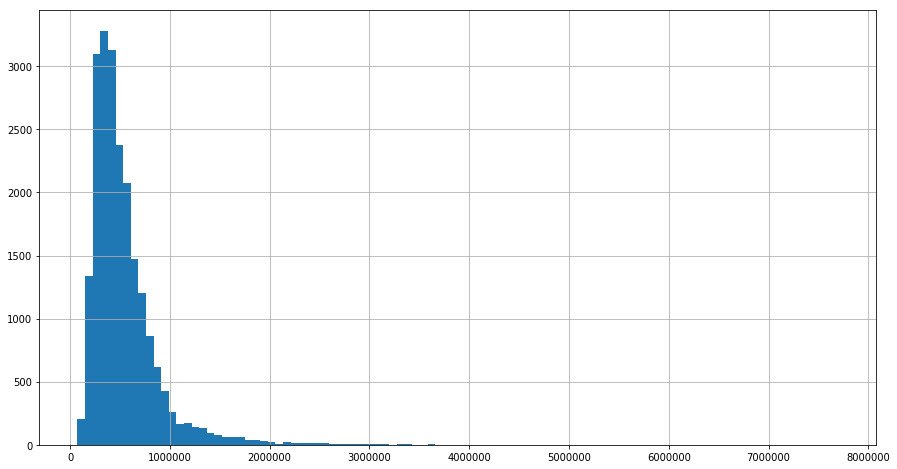

In [4]:
df.price.hist(bins=100, figsize=(15, 8));

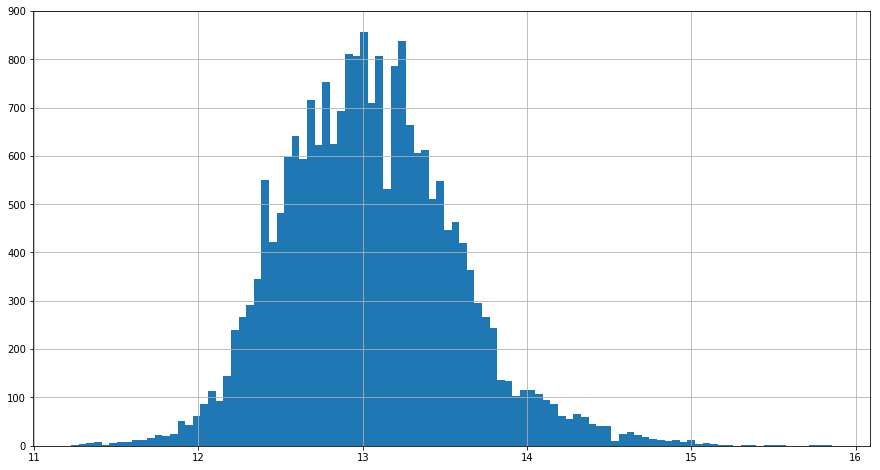

In [5]:
np.log( df.price ).hist(bins=100, figsize=(15, 8));

Let's check what is the decay of target variable.

In [16]:
df['price'].value_counts()

450000.0     172
350000.0     172
550000.0     159
500000.0     152
425000.0     150
325000.0     148
400000.0     145
375000.0     138
300000.0     133
525000.0     131
250000.0     130
475000.0     120
330000.0     119
650000.0     117
275000.0     113
315000.0     111
415000.0     111
280000.0     110
600000.0     110
390000.0     110
440000.0     109
320000.0     108
435000.0     105
340000.0     103
310000.0     101
335000.0      98
420000.0      97
360000.0      96
260000.0      95
265000.0      95
            ... 
1544500.0      1
431750.0       1
234975.0       1
1151250.0      1
804995.0       1
870515.0       1
475500.0       1
225900.0       1
1825000.0      1
394250.0       1
739999.0       1
838300.0       1
386380.0       1
369990.0       1
805500.0       1
3120000.0      1
271675.0       1
2888000.0      1
402723.0       1
369946.0       1
739888.0       1
772650.0       1
304400.0       1
644000.0       1
543200.0       1
641500.0       1
575950.0       1
674250.0      

In [4]:
df['sqft_living'].value_counts()

1300     138
1400     135
1440     133
1010     129
1660     129
1800     129
1820     128
1480     125
1720     125
1540     124
1560     124
1320     122
1250     120
1580     119
1370     118
1200     118
1900     117
1780     117
1650     117
2100     116
1460     116
1680     116
1430     116
1740     115
1830     114
1510     114
1340     113
1260     113
1500     112
1640     112
        ... 
2153       1
2105       1
2007       1
6085       1
2015       1
8020       1
12050      1
1767       1
1639       1
2473       1
440        1
2601       1
3273       1
1528       1
3545       1
1496       1
5530       1
1352       1
3305       1
1256       1
5210       1
2665       1
1048       1
5130       1
3065       1
3001       1
4970       1
2905       1
2793       1
1975       1
Name: sqft_living, Length: 1038, dtype: int64

In [ ]:
price - price_pred!!!

In [ ]:
#
data['gain_minus_loss'] = data['Capital Gain'] - data['Capital Loss']

In [ ]:
Metryka Sukcesu???

## PIPELINE


## First Model

- Let's make our basic model. It's going to be simple and dumb. It's called DummyRegressor.
- It will help us understand where are we now? It will give us first score with which we can compare in the future.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null object
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null object
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(15), object(3)
memory usage: 3.5+ MB


In [78]:
feats = df.select_dtypes(include=[ np.int64, np.object ]).columns.values
feats = feats[ (feats != 'price_pred') & (feats != 'price') & (feats != 'bedrooms_cat')]

X = df[feats].values
y = df['price'].values

In [79]:
feats

array(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15'], dtype=object)

In [76]:
models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median')),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = rmsle(y, y_pred)
    
    print(model_name, score)

TypeError: float() argument must be a string or a number, not 'datetime.datetime'

In [ ]:
models = [
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=2017)),
    ('rf', RandomForestRegressor(max_depth=5, random_state=2017)),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = rmsle(y, y_pred)
    
    print(model_name, score)